---- TEAM ID MATCHING ----
home_team title: NEOM SC -> matched: NEOM id: 3syp26wx3cg4oraxo38b58e22
away_team title: Al Ahli FC -> matched: Al Ahli id: aj1bdyuwq8pdwycaa9kba8uni
--------------------------
---- Goals (typeId=16) counts per contestantId ----
contestantId
aj1bdyuwq8pdwycaa9kba8uni    3
Computed score: 0 - 3

---- Goal events (rows) ----
 timeMin  timeSec              contestantId playerName  eventId         id
      54       23 aj1bdyuwq8pdwycaa9kba8uni   I. Toney      365 2892471171
      63       21 aj1bdyuwq8pdwycaa9kba8uni  R. Mahrez      395 2892477655
      66       34 aj1bdyuwq8pdwycaa9kba8uni  E. Millot      422 2892479317
-----------------------------------------------


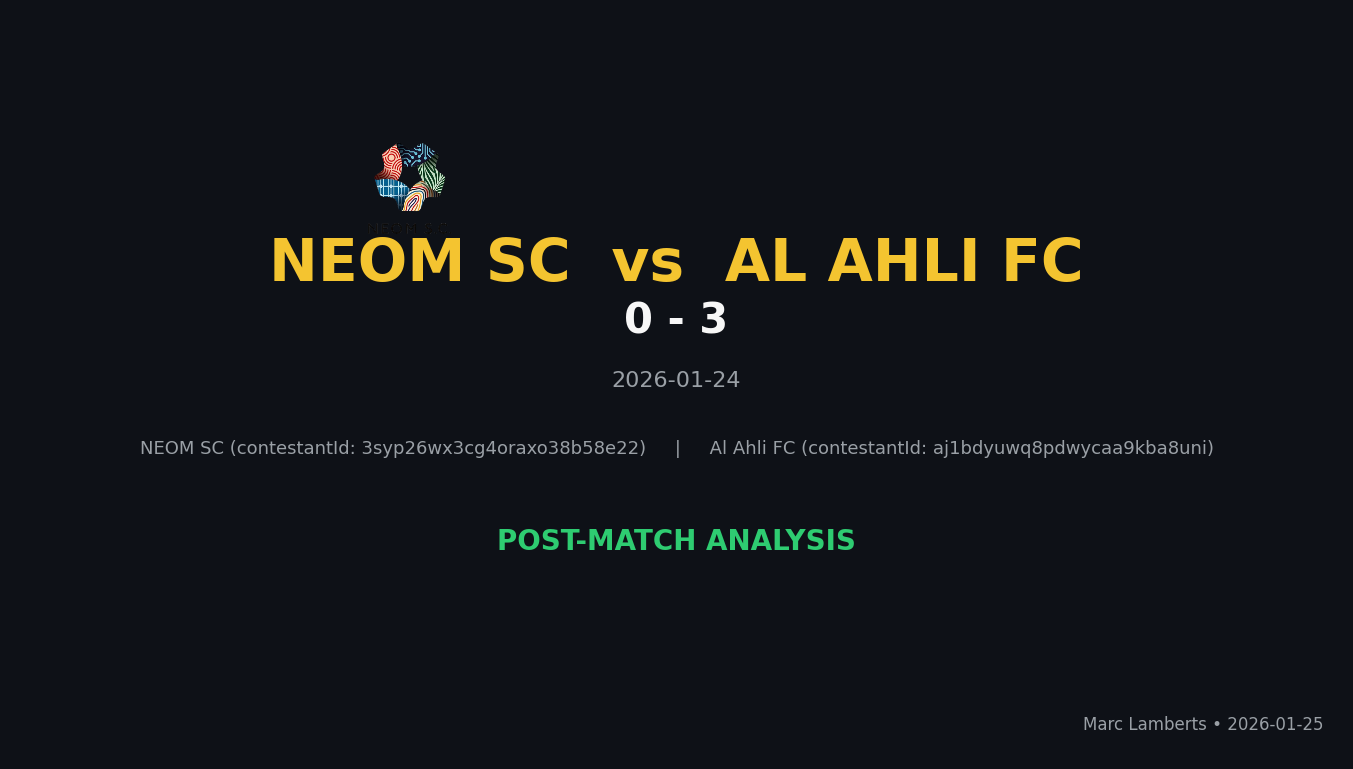

Saved: /Users/user/Downloads/Post-Match NEOM/Page 1.png
Final score (typeId=16 per contestantId): 0 - 3


In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from datetime import date
from difflib import SequenceMatcher

# =====================
# COLORS
# =====================
COLORS = {
    "yellow": "#F4C430",
    "black": "#0B0B0B",
    "white": "#F7F7F7",
    "grey": "#9AA0A6",
    "emerald": "#2ECC71",
    "background": "#0e1117",
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "font.family": "DejaVu Sans",
})

# =====================
# INPUTS
# =====================
json_path   = "/Users/user/XG/Saudi/DONE/2026-01-24_NEOM SC - Al Ahli FC.json"
matches_csv = "/Users/user/XG/Saudi Matches.csv"   # make sure this path is correct
badge_dir   = "/Users/user/Logo/"                  # expects "{TEAM}.png"
out_path    = "/Users/user/Downloads/Post-Match NEOM/Page 1.png"

DEBUG = True  # set False when happy

# =====================
# HELPERS
# =====================
def norm(s: str) -> str:
    return " ".join(str(s).strip().split())

def norm_key(s: str) -> str:
    return norm(s).lower()

def parse_title_from_filename(path: str):
    """
    Expected filename:
      'YYYY-MM-DD_TEAM A - TEAM B.json'
    Returns: date_str, home_team, away_team
    """
    base = os.path.splitext(os.path.basename(path))[0].strip()
    if "_" not in base:
        raise ValueError(f"Filename must contain '_' after date. Got: {base}")
    date_str, rest = base.split("_", 1)
    rest = rest.strip()
    if " - " not in rest:
        raise ValueError(f"Filename must contain ' - ' between teams. Got: {rest}")
    home_team, away_team = [x.strip() for x in rest.split(" - ", 1)]
    return date_str.strip(), home_team, away_team

def add_badge(ax, img_path, xy_axes_frac, zoom):
    if not os.path.exists(img_path):
        return
    img = mpimg.imread(img_path)
    ax.add_artist(
        AnnotationBbox(
            OffsetImage(img, zoom=zoom),
            xy_axes_frac,
            xycoords="axes fraction",
            frameon=False
        )
    )

def load_events_from_json(json_path: str) -> pd.DataFrame:
    """
    Use ONLY the top-level 'event' list (no recursive walk).
    This avoids duplicates and is the correct source for typeId/contestantId.
    """
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️ Could not read {json_path}: {e}")
        return pd.DataFrame()

    events = data.get("event", [])
    if not isinstance(events, list) or len(events) == 0:
        print("⚠️ No 'event' list found in JSON.")
        return pd.DataFrame()

    df = pd.json_normalize(events, sep="_")

    for col in ["typeId", "contestantId", "timeMin", "timeSec", "playerName", "eventId", "id"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["typeId"] = pd.to_numeric(df["typeId"], errors="coerce")
    df["contestantId"] = df["contestantId"].astype("string")
    df["timeMin"] = pd.to_numeric(df["timeMin"], errors="coerce")
    df["timeSec"] = pd.to_numeric(df["timeSec"], errors="coerce")

    return df

def build_team_map(matches_csv_path: str) -> pd.DataFrame:
    teams = pd.read_csv(matches_csv_path)

    needed_h = ["matchInfo/contestant/0/name", "matchInfo/contestant/0/id"]
    needed_a = ["matchInfo/contestant/1/name", "matchInfo/contestant/1/id"]

    missing = [c for c in (needed_h + needed_a) if c not in teams.columns]
    if missing:
        raise ValueError(
            "Saudi Matches.csv does not contain expected columns:\n"
            f"Missing: {missing}\n"
            f"Available (sample): {list(teams.columns)[:30]}"
        )

    h = teams[needed_h].copy()
    a = teams[needed_a].copy()
    h.columns = a.columns = ["Team", "contestantId"]
    team_map = pd.concat([h, a]).drop_duplicates()
    team_map["Team_norm"] = team_map["Team"].astype(str).map(norm_key)
    team_map["contestantId"] = team_map["contestantId"].astype(str)
    return team_map

def best_match_team_id(team_name: str, team_map: pd.DataFrame) -> str:
    """
    Find contestantId for team_name using:
    1) exact normalized match
    2) fuzzy best match (SequenceMatcher)
    """
    key = norm_key(team_name)
    exact = team_map.loc[team_map["Team_norm"] == key, "contestantId"]
    if len(exact) > 0:
        return exact.iloc[0]

    candidates = team_map["Team_norm"].unique().tolist()
    if not candidates:
        return ""

    def sim(a, b):
        return SequenceMatcher(None, a, b).ratio()

    best = max(candidates, key=lambda c: sim(key, c))
    best_id = team_map.loc[team_map["Team_norm"] == best, "contestantId"].iloc[0]
    return best_id

def goal_counts_by_contestant(events_df: pd.DataFrame) -> pd.Series:
    goals = events_df[events_df["typeId"] == 16].copy()
    return goals.groupby("contestantId", dropna=True).size().sort_values(ascending=False)

# =====================
# TEAMS FROM FILENAME
# =====================
date_str, home_team, away_team = parse_title_from_filename(json_path)

# =====================
# TEAM IDS FROM Saudi Matches.csv
# =====================
team_map = build_team_map(matches_csv)
home_id = best_match_team_id(home_team, team_map)
away_id = best_match_team_id(away_team, team_map)

if DEBUG:
    home_match_name = (
        team_map.loc[team_map["contestantId"] == home_id, "Team"].iloc[0]
        if home_id and (team_map["contestantId"] == home_id).any()
        else "—"
    )
    away_match_name = (
        team_map.loc[team_map["contestantId"] == away_id, "Team"].iloc[0]
        if away_id and (team_map["contestantId"] == away_id).any()
        else "—"
    )
    print("---- TEAM ID MATCHING ----")
    print("home_team title:", home_team, "-> matched:", home_match_name, "id:", home_id or "—")
    print("away_team title:", away_team, "-> matched:", away_match_name, "id:", away_id or "—")
    print("--------------------------")

# =====================
# EVENTS -> GOALS PER contestantId (typeId == 16)
# =====================
events_df = load_events_from_json(json_path)
counts = goal_counts_by_contestant(events_df)

home_goals = int(counts.get(str(home_id), 0)) if home_id else 0
away_goals = int(counts.get(str(away_id), 0)) if away_id else 0
score = f"{home_goals} - {away_goals}"

if DEBUG:
    print("---- Goals (typeId=16) counts per contestantId ----")
    if len(counts) == 0:
        print("No typeId=16 found.")
    else:
        print(counts.to_string())
    print("Computed score:", score)

    goals_df = events_df[events_df["typeId"] == 16].copy()
    cols = [c for c in ["timeMin", "timeSec", "contestantId", "playerName", "eventId", "id"] if c in goals_df.columns]
    print("\n---- Goal events (rows) ----")
    if len(goals_df) == 0:
        print("No goal rows.")
    else:
        print(goals_df[cols].sort_values(["timeMin", "timeSec"], na_position="last").to_string(index=False))
    print("-----------------------------------------------")

# =====================
# FIGURE (PowerPoint 16:9)
# =====================
fig = plt.figure(figsize=(13.33, 7.5))  # PPT 16:9
fig.patch.set_facecolor(COLORS["background"])
ax = fig.add_axes([0, 0, 1, 1])
ax.axis("off")

# =====================
# TEXT BLOCKS
# =====================
# Team names line
ax.text(
    0.5, 0.66,
    f"{home_team.upper()}  vs  {away_team.upper()}",
    ha="center", va="center",
    fontsize=42, fontweight="bold",
    color=COLORS["yellow"]
)

# Logos ABOVE team names
logo_y = 0.76
logo_zoom = 0.25
add_badge(ax, os.path.join(badge_dir, f"{home_team}.png"), (0.30, logo_y), zoom=logo_zoom)
add_badge(ax, os.path.join(badge_dir, f"{away_team}.png"), (0.70, logo_y), zoom=logo_zoom)

# Score
ax.text(
    0.5, 0.585,
    score,
    ha="center", va="center",
    fontsize=30, fontweight="bold",
    color=COLORS["white"]
)

# Date line (simple + reliable)
ax.text(
    0.5, 0.505,
    date_str,
    ha="center", va="center",
    fontsize=16,
    color=COLORS["grey"]
)

# contestantId line
ax.text(
    0.5, 0.415,
    f"{home_team} (contestantId: {home_id or '—'})     |     {away_team} (contestantId: {away_id or '—'})",
    ha="center", va="center",
    fontsize=13,
    color=COLORS["grey"]
)

# Subtitle
ax.text(
    0.5, 0.29,
    "POST-MATCH ANALYSIS",
    ha="center", va="center",
    fontsize=20, fontweight="bold",
    color=COLORS["emerald"]
)

# Made by (bottom-right)
today_str = date.today().strftime("%Y-%m-%d")
ax.text(
    0.985, 0.035,
    f"Marc Lamberts • {today_str}",
    ha="right", va="bottom",
    fontsize=12,
    color=COLORS["grey"]
)

# =====================
# SAVE (PPT SAFE)
# =====================
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.savefig(
    out_path,
    dpi=300,
    facecolor=fig.get_facecolor(),
    bbox_inches=None,  # keep exact 16:9 canvas
    transparent=False
)
plt.show()

print("Saved:", out_path)
print("Final score (typeId=16 per contestantId):", score)


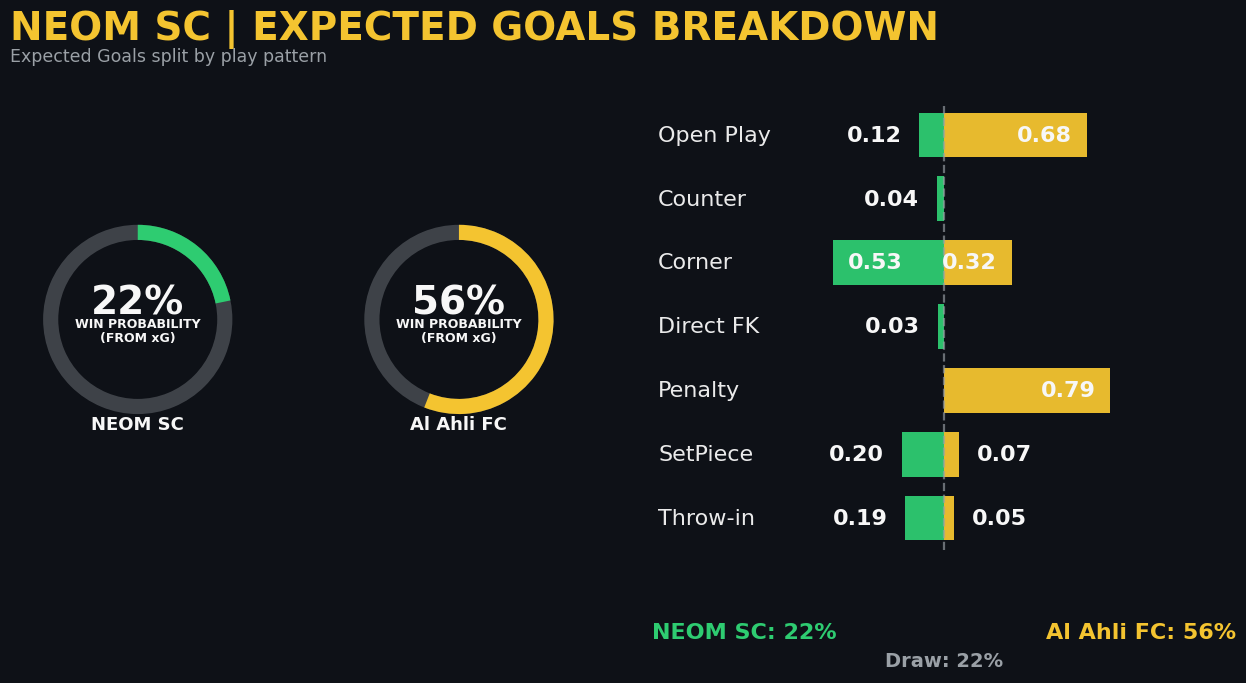

Saved: xg_play_pattern_ppt.png
Saved: /Users/user/Downloads/Post-Match NEOM/Page 2.png
Matched keys -> HOME: NEOM SC | AWAY: Al Ahli FC
HOME xG total: 1.1056202985346313 | AWAY xG total: 1.903590814173222
Win probs from xG -> HOME: 0.21783309454604027 DRAW: 0.22238741589544736 AWAY: 0.5597794895585124
Check sum: 1.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Wedge
import math

# =====================
# COLORS
# =====================
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
    'background': '#0e1117'
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "axes.labelcolor": COLORS["white"],
    "xtick.color": COLORS["grey"],
    "ytick.color": COLORS["grey"],
    "font.family": "DejaVu Sans",
})

# =====================
# PLAY PATTERN RENAME MAP
# =====================
PATTERN_RENAME = {
    "DirectFreekick": "Direct FK",
    "FastBreak": "Counter",
    "ThrowinSetPiece": "Throw-in",
    "FromCorner": "Corner",
    "RegularPlay": "Open Play",
}

# =====================
# CSV CONFIG
# =====================
CSV_PATH = "/Users/user/XG/Saudi/xgCSV/2026-01-24_NEOM SC - Al Ahli FC.csv"

TEAM_COL = "TeamId"
PATTERN_COL = "Type_of_play"
XG_COL = "xG"

HOME_TEAM = "NEOM SC"
AWAY_TEAM = "Al Ahli FC"

# Title always NEOM SC (branding only)
CLUB_FOR_TITLE = "NEOM SC"

# =====================
# HELPERS
# =====================
def _norm(s):
    return str(s).strip().lower()

def get_team_key(df, team_col, target_name):
    """Return the exact key in df[team_col] that matches target_name (case/space-insensitive)."""
    target = _norm(target_name)
    uniques = df[team_col].dropna().unique().tolist()
    for u in uniques:
        if _norm(u) == target:
            return u
    return None

def rename_patterns(xg_dict):
    return {PATTERN_RENAME.get(k, k): float(v) for k, v in xg_dict.items()}

# =====================
# WIN PROBABILITY FROM xG (Poisson)
# =====================
def poisson_pmf(k: int, lam: float) -> float:
    if lam < 0:
        return 0.0
    return math.exp(-lam) * (lam ** k) / math.factorial(k)

def win_probs_from_xg(home_xg: float, away_xg: float, max_goals: int = 12):
    """
    Returns (home_win_prob, draw_prob, away_win_prob) using Poisson scoreline model.
    IMPORTANT: Correct triangle directions.
    """
    home_probs = np.array([poisson_pmf(k, home_xg) for k in range(max_goals + 1)], dtype=float)
    away_probs = np.array([poisson_pmf(k, away_xg) for k in range(max_goals + 1)], dtype=float)

    # rows = i (home goals), cols = j (away goals)
    score_mat = np.outer(home_probs, away_probs)

    # Correct:
    # home win = i > j = BELOW diagonal
    # away win = i < j = ABOVE diagonal
    home_win = float(np.tril(score_mat, k=-1).sum())
    draw     = float(np.trace(score_mat))
    away_win = float(np.triu(score_mat, k=1).sum())

    # Renormalize to account for small tail mass beyond max_goals
    total = home_win + draw + away_win
    if total > 0:
        home_win /= total
        draw     /= total
        away_win /= total

    return home_win, draw, away_win

# =====================
# LOAD + AGGREGATE DATA
# =====================
df = pd.read_csv(CSV_PATH)

# Match TeamId keys robustly
home_key = get_team_key(df, TEAM_COL, HOME_TEAM)
away_key = get_team_key(df, TEAM_COL, AWAY_TEAM)

unique_teams = df[TEAM_COL].dropna().unique().tolist()
if home_key is None or away_key is None:
    # fallback: pick first two teams in file so you don't silently get zeros
    if len(unique_teams) >= 2:
        if home_key is None:
            home_key = unique_teams[0]
        if away_key is None:
            away_key = unique_teams[1]

# xG by play pattern (for bars)
xg_by_pattern = (
    df.groupby([TEAM_COL, PATTERN_COL], dropna=False)[XG_COL]
      .sum()
      .reset_index()
)

home_xg_raw = (
    xg_by_pattern[xg_by_pattern[TEAM_COL] == home_key]
    .set_index(PATTERN_COL)[XG_COL]
    .to_dict()
)
away_xg_raw = (
    xg_by_pattern[xg_by_pattern[TEAM_COL] == away_key]
    .set_index(PATTERN_COL)[XG_COL]
    .to_dict()
)

left_xg  = rename_patterns(home_xg_raw)  # bars LEFT = HOME
right_xg = rename_patterns(away_xg_raw)  # bars RIGHT = AWAY

# xG totals per TeamId (used for win probs)
xg_totals = df.groupby(TEAM_COL, dropna=False)[XG_COL].sum()
home_xg_total = float(xg_totals.get(home_key, 0.0))
away_xg_total = float(xg_totals.get(away_key, 0.0))

home_prob, draw_prob, away_prob = win_probs_from_xg(home_xg_total, away_xg_total, max_goals=12)
home_prob = float(np.clip(home_prob, 0, 1))
away_prob = float(np.clip(away_prob, 0, 1))
draw_prob = float(np.clip(draw_prob, 0, 1))

# =====================
# LABEL PLACEMENT HELPERS
# =====================
def _x_for_left_value(v, lim):
    if v <= 0:
        return None, None
    if v >= 0.22 * lim:
        return (-v + 0.05 * lim), "left"   # inside
    return (-v - 0.06 * lim), "right"      # outside left

def _x_for_right_value(v, lim):
    if v <= 0:
        return None, None
    if v >= 0.22 * lim:
        return (v - 0.05 * lim), "right"   # inside
    return (v + 0.06 * lim), "left"        # outside right

# =====================
# PLOT FUNCTION (PPT 16:9 + header + footer probs)
# =====================
def plot_xg_play_pattern_ppt(
    home_team_label,
    away_team_label,
    home_prob,
    away_prob,
    draw_prob,
    left_xg,
    right_xg,
    header_title=None,
    header_subtitle=None,
    left_color=COLORS["emerald"],
    right_color=COLORS["yellow"],
):
    # FORCE DISPLAY ORDER: Open Play first, Counter second, then the rest (alphabetical)
    ORDER_PRIORITY = {"Open Play": 0, "Counter": 1}
    cats_union = list(dict.fromkeys(list(left_xg.keys()) + list(right_xg.keys())))
    cats = sorted(cats_union, key=lambda c: (ORDER_PRIORITY.get(c, 99), c))

    left_vals = np.array([float(left_xg.get(c, 0.0)) for c in cats])
    right_vals = np.array([float(right_xg.get(c, 0.0)) for c in cats])

    # 16:9 canvas
    fig = plt.figure(figsize=(13.33, 7.5))

    gs = fig.add_gridspec(
        nrows=2, ncols=3,
        height_ratios=[12, 1.6],
        width_ratios=[1.05, 1.05, 2.4],
        left=0.05, right=0.97, top=0.86, bottom=0.10,
        wspace=0.18, hspace=0.25
    )

    ax_g1 = fig.add_subplot(gs[0, 0])
    ax_g2 = fig.add_subplot(gs[0, 1])
    ax_b  = fig.add_subplot(gs[0, 2])
    ax_footer = fig.add_subplot(gs[1, 2])

    for ax in (ax_g1, ax_g2, ax_b, ax_footer):
        ax.set_facecolor(COLORS["background"])

    # Header text
    if header_title:
        fig.text(0.05, 0.945, header_title,
                 fontsize=28, fontweight="bold", color=COLORS["yellow"])
    if header_subtitle:
        fig.text(0.05, 0.915, header_subtitle,
                 fontsize=12.5, color=COLORS["grey"])

    # Donut helper
    def draw_donut(ax, prob, team, color):
        ax.set_aspect("equal")
        ax.axis("off")

        r = 1.0
        ring_w = 0.16

        ax.add_patch(Wedge((0, 0), r, 0, 360, width=ring_w,
                           facecolor=COLORS["grey"], alpha=0.35, edgecolor="none"))
        prob = float(np.clip(prob, 0, 1))
        ax.add_patch(Wedge((0, 0), r, 90 - 360 * prob, 90, width=ring_w,
                           facecolor=color, edgecolor="none"))

        ax.text(0, 0.18, f"{int(round(prob * 100))}%",
                ha="center", va="center",
                fontsize=28, fontweight="bold", color=COLORS["white"])

        ax.text(0, -0.12, "WIN PROBABILITY\n(FROM xG)",
                ha="center", va="center",
                fontsize=9, fontweight="bold",
                color=COLORS["white"], linespacing=1.15)

        ax.text(0, -1.11, team,
                ha="center", va="center",
                fontsize=13, fontweight="bold",
                color=COLORS["white"])

        ax.set_xlim(-1.35, 1.35)
        ax.set_ylim(-1.40, 1.25)

    # DO NOT SWAP: left donut = HOME, right donut = AWAY
    draw_donut(ax_g1, home_prob, home_team_label, left_color)
    draw_donut(ax_g2, away_prob, away_team_label, right_color)

    # Bars
    y = np.arange(len(cats))
    maxv = max(left_vals.max(initial=0), right_vals.max(initial=0))
    lim = max(0.6, maxv + 0.6)

    ax_b.barh(y, -left_vals, height=0.70, color=left_color, alpha=0.95)
    ax_b.barh(y,  right_vals, height=0.70, color=right_color, alpha=0.95)
    ax_b.axvline(0, color=COLORS["grey"], lw=1.6, ls="--", alpha=0.65)

    # Category labels
    cat_x = -lim * 0.98
    for yi, c in zip(y, cats):
        ax_b.text(cat_x, yi, c, ha="left", va="center",
                  fontsize=16, color=COLORS["white"], alpha=0.95)

    # Value labels
    for yi, v in zip(y, left_vals):
        x, ha = _x_for_left_value(v, lim)
        if x is not None:
            ax_b.text(x, yi, f"{v:.2f}",
                      ha=ha, va="center",
                      fontsize=16, fontweight="bold", color=COLORS["white"])

    for yi, v in zip(y, right_vals):
        x, ha = _x_for_right_value(v, lim)
        if x is not None:
            ax_b.text(x, yi, f"{v:.2f}",
                      ha=ha, va="center",
                      fontsize=16, fontweight="bold", color=COLORS["white"])

    ax_b.set_xlim(-lim, lim)
    ax_b.set_ylim(-0.5, len(cats) - 0.5)
    ax_b.set_xticks([])
    ax_b.set_yticks([])
    ax_b.invert_yaxis()
    for spine in ax_b.spines.values():
        spine.set_visible(False)

    # Footer probs
    ax_footer.axis("off")
    ax_footer.text(0.00, 0.68, f"{home_team_label}: {int(round(home_prob*100))}%",
                   color=left_color, fontsize=16, fontweight="bold",
                   ha="left", va="center", transform=ax_footer.transAxes)
    ax_footer.text(1.00, 0.68, f"{away_team_label}: {int(round(away_prob*100))}%",
                   color=right_color, fontsize=16, fontweight="bold",
                   ha="right", va="center", transform=ax_footer.transAxes)
    ax_footer.text(0.50, 0.20, f"Draw: {int(round(draw_prob*100))}%",
                   color=COLORS["grey"], fontsize=14, fontweight="bold",
                   ha="center", va="center", transform=ax_footer.transAxes)

    return fig

# =====================
# RUN + SAVE (NO CUTOFF)
# =====================
fig = plot_xg_play_pattern_ppt(
    home_team_label=HOME_TEAM,
    away_team_label=AWAY_TEAM,
    home_prob=home_prob,
    away_prob=away_prob,
    draw_prob=draw_prob,
    left_xg=left_xg,
    right_xg=right_xg,
    header_title=f"{CLUB_FOR_TITLE.upper()} | EXPECTED GOALS BREAKDOWN",
    header_subtitle="Expected Goals split by play pattern",
)

out_local = "xg_play_pattern_ppt.png"
out_folder = "/Users/user/Downloads/Post-Match NEOM/Page 2.png"

for out in (out_local, out_folder):
    fig.savefig(
        out,
        dpi=300,
        facecolor=COLORS["background"],
        bbox_inches=None,   # do not trim
        pad_inches=0.0,     # keep exact 16:9 canvas
        transparent=False
    )

plt.show()

print("Saved:", out_local)
print("Saved:", out_folder)
print("Matched keys -> HOME:", home_key, "| AWAY:", away_key)
print("HOME xG total:", home_xg_total, "| AWAY xG total:", away_xg_total)
print("Win probs from xG -> HOME:", home_prob, "DRAW:", draw_prob, "AWAY:", away_prob)
print("Check sum:", home_prob + draw_prob + away_prob)


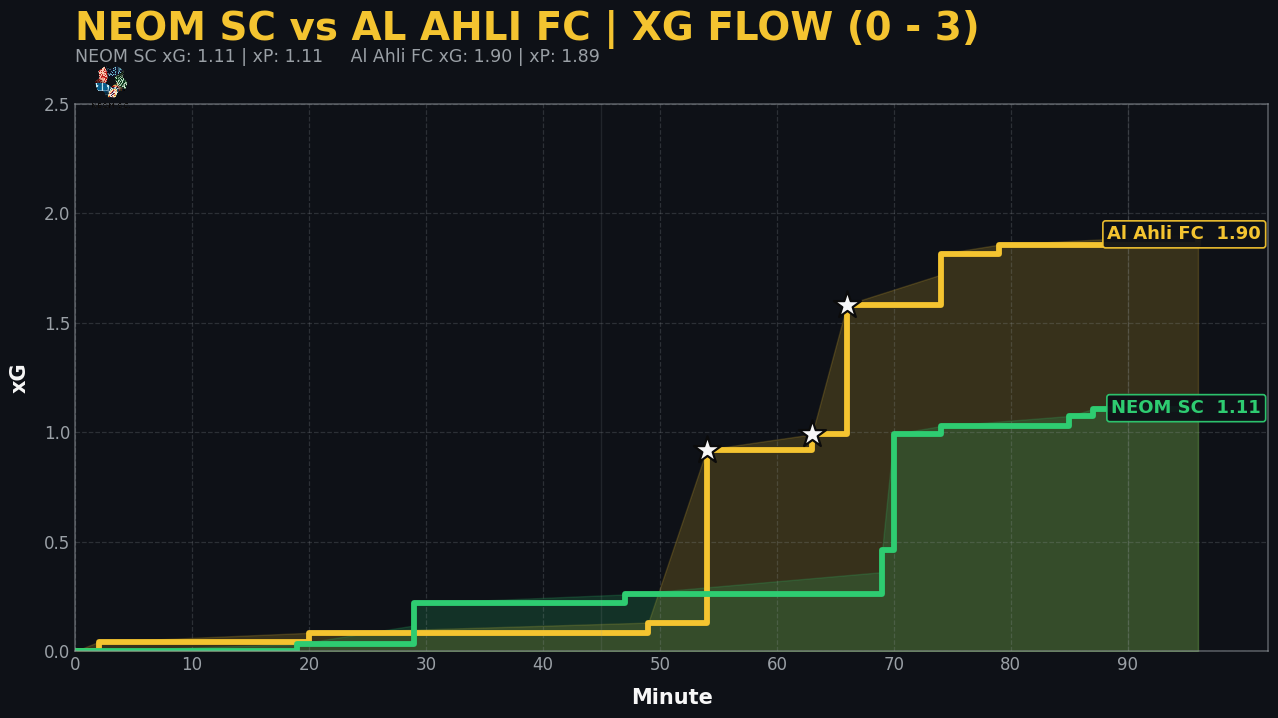

Saved: /Users/user/Downloads/Post-Match NEOM/Page 3.png
Cutoff minute (XMAX): 96.0
Y max (YMAX): 2.5


In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# =====================
# COLORS (your palette)
# =====================
COLORS = {
    'yellow': '#F4C430',
    'black': '#0B0B0B',
    'white': '#F7F7F7',
    'grey': '#9AA0A6',
    'emerald': '#2ECC71',
    'background': '#0e1117'
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "axes.labelcolor": COLORS["white"],
    "xtick.color": COLORS["grey"],
    "ytick.color": COLORS["grey"],
    "font.family": "DejaVu Sans",
})

# =====================
# INPUTS
# =====================
file_path = "/Users/user/XG/Saudi/xgCSV/2026-01-24_NEOM SC - Al Ahli FC.csv"
badge_dir = "/Users/user/Logo/"                  # expects "{TEAMNAME}.png"
brand_logo_path = "/Users/user/Logo/.png"        # optional
out_path = "/Users/user/Downloads/Post-Match NEOM/Page 3.png"   

# =====================
# LOAD + CLEAN
# =====================
df = pd.read_csv(file_path)

# Remove penalties at or after 120'
if "timeMin" in df.columns and "Type_of_play" in df.columns:
    df = df[~((df["timeMin"] >= 120) & (df["Type_of_play"] == "Penalty"))]

# Team names
hteam = str(df["HomeTeam"].iloc[0])
ateam = str(df["AwayTeam"].iloc[-1])

# =====================
# CUTOFF (XMAX): last timeMin with an xG event
# =====================
xg_col = "xG"
time_col = "timeMin"

xg_valid = df[xg_col].notna() & (df[xg_col].astype(float) > 0)

if xg_valid.any():
    XMAX = float(df.loc[xg_valid, time_col].max())
else:
    XMAX = float(df[time_col].max()) if time_col in df.columns else 120.0

XMAX = float(np.ceil(XMAX))  # nicer axis end

# =====================
# BUILD CUMULATIVE xG
# =====================
a_xg, h_xg = [0.0], [0.0]
a_min, h_min = [0.0], [0.0]
a_goals_min, h_goals_min = [], []

for _, row in df.iterrows():
    team = row.get("TeamId", None)
    tmin = float(row.get(time_col, 0))
    xg   = float(row.get(xg_col, 0))
    goal = int(row.get("isGoal", 0))

    if team == ateam:
        a_xg.append(xg); a_min.append(tmin)
        if goal == 1:
            a_goals_min.append(tmin)
    elif team == hteam:
        h_xg.append(xg); h_min.append(tmin)
        if goal == 1:
            h_goals_min.append(tmin)

def cumulative(xs):
    s = 0.0
    out = []
    for v in xs:
        s += float(v)
        out.append(s)
    return out

a_cum = cumulative(a_xg)
h_cum = cumulative(h_xg)

alast = float(round(a_cum[-1], 2))
hlast = float(round(h_cum[-1], 2))

# Extend trailing points so the step holds flat to XMAX (true match end)
if a_min[-1] < XMAX:
    a_min.append(XMAX); a_cum.append(alast)
if h_min[-1] < XMAX:
    h_min.append(XMAX); h_cum.append(hlast)

# =====================
# YMAX: based on highest cumulative xG (+ headroom)
# =====================
peak_xg = float(max(max(a_cum), max(h_cum)))
YMAX = float(np.ceil((peak_xg + 0.35) * 2) / 2)  # round up to nearest 0.5
YMAX = max(1.5, YMAX)

y_step = 0.5 if YMAX <= 3 else 1.0

# =====================
# "WIN PROB" + xP (xG-share heuristic)
# =====================
total_xg = alast + hlast
away_win_prob = (alast / total_xg) if total_xg else 0.5
home_win_prob = (hlast / total_xg) if total_xg else 0.5
draw_prob = max(0.0, 1.0 - (away_win_prob + home_win_prob))

away_xp = round(3 * away_win_prob + draw_prob, 2)
home_xp = round(3 * home_win_prob + draw_prob, 2)

# =====================
# STYLING
# =====================
BG = COLORS["background"]
home_col = COLORS["emerald"]
away_col = COLORS["yellow"]
goal_col = COLORS["white"]

# =====================
# HELPERS
# =====================
def add_badge(ax, img_path, xy_axes_frac, zoom):
    if not os.path.exists(img_path):
        return
    img = mpimg.imread(img_path)
    ab = AnnotationBbox(
        OffsetImage(img, zoom=zoom),
        xy_axes_frac,
        xycoords="axes fraction",
        frameon=False
    )
    ab.set_clip_on(False)  # prevent clipping at the axes boundary
    ax.add_artist(ab)

def _cum_at_min(min_list, cum_list, minute):
    if minute in min_list:
        return cum_list[min_list.index(minute)]
    idx = max(i for i, m in enumerate(min_list) if m <= minute)
    return cum_list[idx]

# =====================
# PLOT (PowerPoint 16:9)
# =====================
fig, ax = plt.subplots(figsize=(13.33, 7.5))  # exact 16:9 slide size
fig.set_facecolor(BG)
ax.set_facecolor(BG)

# PowerPoint-friendly safe margins (slightly more breathing room)
fig.subplots_adjust(left=0.075, right=0.97, bottom=0.11, top=0.84)

# Spines
for spine in ax.spines.values():
    spine.set_color(COLORS["grey"])
    spine.set_alpha(0.55)
    spine.set_linewidth(1.1)

# Grid
ax.grid(ls="--", lw=0.9, color=COLORS["grey"], alpha=0.22)

# Limits (add right padding so end labels never get clipped)
RIGHT_PAD = 6  # minutes of empty space at the right edge
ax.set_xlim(0, XMAX + RIGHT_PAD)
ax.set_ylim(0, YMAX)

# Ticks
tick_step = 10 if XMAX <= 100 else 15
ax.set_xticks(np.arange(0, XMAX + 0.001, tick_step))
ax.set_yticks(np.arange(0, YMAX + 0.001, y_step))

ax.tick_params(axis="both", which="major", colors=COLORS["grey"], labelsize=12, length=0)

# Labels
ax.set_xlabel("Minute", fontsize=15, fontweight="bold", color=COLORS["white"], labelpad=10)
ax.set_ylabel("xG", fontsize=15, fontweight="bold", color=COLORS["white"], labelpad=10)

# Area + steps
ax.fill_between(a_min, a_cum, color=away_col, alpha=0.18)
ax.fill_between(h_min, h_cum, color=home_col, alpha=0.18)

ax.step(a_min, a_cum, where="post", color=away_col, lw=4.2,
        solid_capstyle="round", solid_joinstyle="round")
ax.step(h_min, h_cum, where="post", color=home_col, lw=4.2,
        solid_capstyle="round", solid_joinstyle="round")

# Goals
for g in a_goals_min:
    yv = _cum_at_min(a_min, a_cum, g)
    ax.scatter(g, yv, marker="*", s=420, facecolor=goal_col,
               edgecolor=COLORS["black"], linewidth=1.6, zorder=6)

for g in h_goals_min:
    yv = _cum_at_min(h_min, h_cum, g)
    ax.scatter(g, yv, marker="*", s=420, facecolor=goal_col,
               edgecolor=COLORS["black"], linewidth=1.6, zorder=6)

# End labels (anchored inside the padded right side)
label_x = XMAX + RIGHT_PAD - 0.6
bbox_kw_away = dict(boxstyle="round,pad=0.25,rounding_size=0.15", fc=BG, ec=away_col, lw=1.2, alpha=0.95)
bbox_kw_home = dict(boxstyle="round,pad=0.25,rounding_size=0.15", fc=BG, ec=home_col, lw=1.2, alpha=0.95)

ax.text(label_x, a_cum[-1], f"{ateam}  {alast:.2f}",
        fontsize=13, color=away_col, va="center", ha="right",
        fontweight="bold", bbox=bbox_kw_away, clip_on=False)
ax.text(label_x, h_cum[-1], f"{hteam}  {hlast:.2f}",
        fontsize=13, color=home_col, va="center", ha="right",
        fontweight="bold", bbox=bbox_kw_home, clip_on=False)

# Guides at 45 & 90 if in range (true match range only)
for vline in (45, 90):
    if vline <= XMAX:
        ax.axvline(vline, color=COLORS["grey"], alpha=0.14, lw=1)

# =====================
# HEADER (your style)
# =====================
score = f"{len(h_goals_min)} - {len(a_goals_min)}"
header_title = f"{hteam.upper()} vs {ateam.upper()} | XG FLOW ({score})"
header_sub = f"{hteam} xG: {hlast:.2f} | xP: {home_xp:.2f}     {ateam} xG: {alast:.2f} | xP: {away_xp:.2f}"

fig.text(0.075, 0.965, header_title,
         fontsize=28, fontweight="bold", color=COLORS["yellow"], ha="left", va="top")
fig.text(0.075, 0.915, header_sub,
         fontsize=12.5, color=COLORS["grey"], ha="left", va="top")

# =====================
# BADGES + BRAND
# =====================
badge1_path = os.path.join(badge_dir, f"{hteam}.png")
badge2_path = os.path.join(badge_dir, f"{ateam}.png")

# Place badges slightly above the axes but not too high; avoid clipping
add_badge(ax, badge1_path, (0.03, 1.03), zoom=0.115)
add_badge(ax, badge2_path, (0.97, 1.03), zoom=0.115)

if os.path.exists(brand_logo_path):
    logo_img = mpimg.imread(brand_logo_path)
    ab = AnnotationBbox(
        OffsetImage(logo_img, zoom=0.06),
        (0.965, 0.945),
        xycoords="figure fraction",
        frameon=False
    )
    ab.set_clip_on(False)
    fig.add_artist(ab)

# =====================
# SAVE (PowerPoint-safe: no bbox_inches="tight")
# =====================
plt.savefig(
    out_path,
    dpi=300,
    facecolor=fig.get_facecolor(),
    bbox_inches=None,
    transparent=False
)
plt.show()

print(f"Saved: {out_path}")
print(f"Cutoff minute (XMAX): {XMAX}")
print(f"Y max (YMAX): {YMAX}")


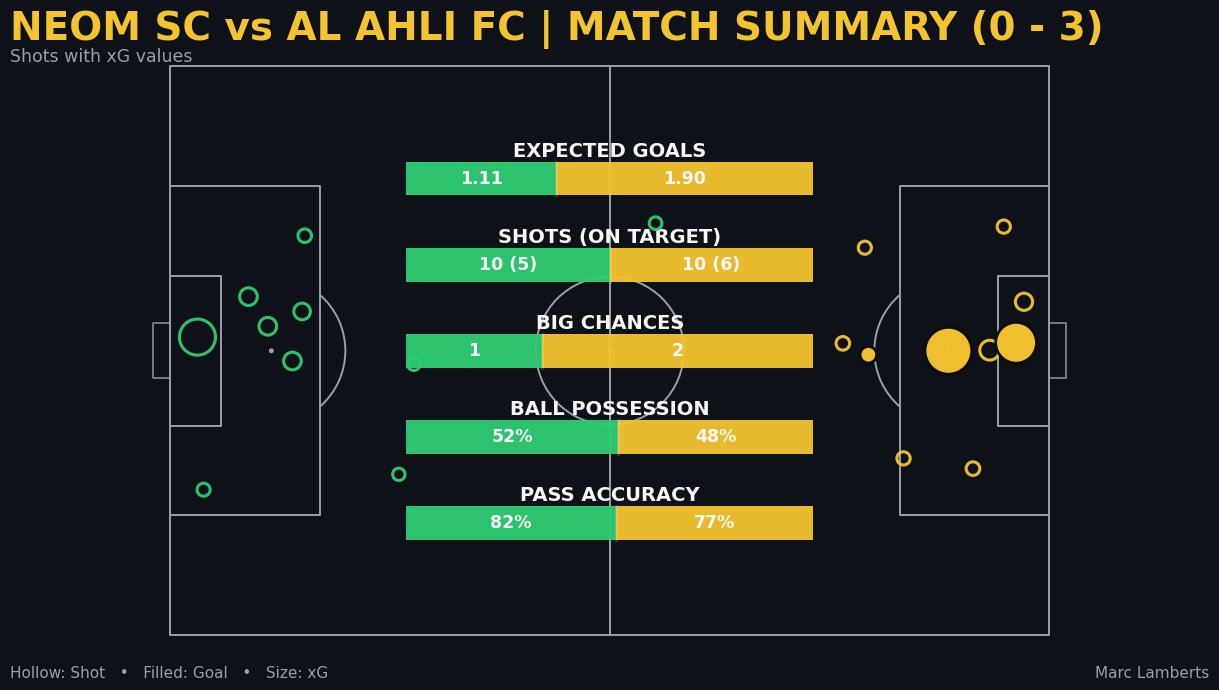

Saved: /Users/user/Downloads/Post-Match NEOM/Page 4.png
Home/Away: NEOM SC / Al Ahli FC
Score: 0 - 3
xG: 1.1056202985346313 - 1.903590814173222
Shots (SOT): 10 (5) - 10 (6)
Big Chances: 1 - 2
Possession (pass-share proxy): 52 - 48
Pass acc: 82 - 77


In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mplsoccer.pitch import Pitch

# =====================
# COLORS (your palette)
# =====================
COLORS = {
    "yellow": "#F4C430",
    "black": "#0B0B0B",
    "white": "#F7F7F7",
    "grey": "#9AA0A6",
    "emerald": "#2ECC71",
    "background": "#0e1117",
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "axes.labelcolor": COLORS["white"],
    "xtick.color": COLORS["grey"],
    "ytick.color": COLORS["grey"],
    "font.family": "DejaVu Sans",
})

# =====================
# INPUTS
# =====================
CSV_PATH  = "/Users/user/XG/Saudi/xgCSV/2026-01-24_NEOM SC - Al Ahli FC.csv"
JSON_PATH = "/Users/user/XG/Saudi/DONE/2026-01-24_NEOM SC - Al Ahli FC.json"
OUT_PATH  = "/Users/user/Downloads/Post-Match NEOM/Page 4.png"   # change if you want

# =====================
# OPTA TYPES (event feed)
# =====================
TYPE_GOAL = 16
TYPE_SHOT_ON_TARGET = 15
TYPE_PASS = 1

# =====================
# HELPERS
# =====================
def _to_bool(v):
    if isinstance(v, str):
        return v.strip().lower() in ("1", "true", "yes", "y", "t")
    return bool(v)

def safe_div(a, b, default=0.0):
    return a / b if b else default

def clamp01(x):
    return float(np.clip(float(x), 0.0, 1.0))

def pct(x):
    return int(round(100 * float(x)))

def load_json_events(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    events = data.get("event", [])
    df = pd.json_normalize(events)
    for c in ["typeId", "contestantId", "outcome", "timeMin", "timeSec"]:
        if c not in df.columns:
            df[c] = np.nan
    df["typeId"] = pd.to_numeric(df["typeId"], errors="coerce")
    df["outcome"] = pd.to_numeric(df["outcome"], errors="coerce")
    df["contestantId"] = df["contestantId"].astype("string")
    return df

def map_contestants_to_home_away(events_df: pd.DataFrame):
    """
    Heuristic:
    - candidate contestantIds are those involved in passes/shots/goals
    - if there is a goal, the scorer contestantId is assumed to be AWAY only if CSV says away scored.
      (We avoid hard assumptions here; for scoring, we still compute by TeamId from CSV first.)
    In practice: we only need contestantIds for possession / pass accuracy & SOT.
    We'll just return the two most common contestantIds in pass events.
    """
    passes = events_df[events_df["typeId"] == TYPE_PASS].copy()
    if passes.empty:
        # fallback: use most common overall
        c = events_df["contestantId"].dropna().astype(str).value_counts()
        ids = c.index.tolist()[:2]
    else:
        c = passes["contestantId"].dropna().astype(str).value_counts()
        ids = c.index.tolist()[:2]
    if len(ids) < 2:
        return None, None
    return ids[0], ids[1]  # home_cid_guess, away_cid_guess (we’ll align later via pass counts)

def draw_stat_row(ax, y_center, label, left_text, right_text, left_share, right_share,
                  left_color, right_color):
    """
    Draw stat bar on ax in AXES COORDS (0..1).
    """
    x0 = 0.28
    w = 0.44
    h = 0.055

    # label
    ax.text(0.5, y_center + 0.045, label.upper(),
            ha="center", va="center",
            fontsize=14, fontweight="bold", color=COLORS["white"],
            transform=ax.transAxes)

    # background
    ax.add_patch(Rectangle((x0, y_center - h/2), w, h,
                           transform=ax.transAxes,
                           facecolor=COLORS["grey"], alpha=0.12, edgecolor="none"))

    left_share = clamp01(left_share)
    right_share = clamp01(right_share)

    wl = w * left_share
    wr = w * right_share

    # blocks
    ax.add_patch(Rectangle((x0, y_center - h/2), wl, h,
                           transform=ax.transAxes,
                           facecolor=left_color, alpha=0.95, edgecolor="none"))
    ax.add_patch(Rectangle((x0 + wl, y_center - h/2), wr, h,
                           transform=ax.transAxes,
                           facecolor=right_color, alpha=0.95, edgecolor="none"))

    # divider
    ax.plot([x0 + wl, x0 + wl], [y_center - h/2, y_center + h/2],
            transform=ax.transAxes, color=COLORS["white"], alpha=0.18, lw=2)

    # texts
    ax.text(x0 + max(wl/2, 0.02), y_center, left_text,
            ha="center", va="center",
            fontsize=12.5, fontweight="bold", color=COLORS["white"],
            transform=ax.transAxes)

    ax.text(x0 + wl + max(wr/2, 0.02), y_center, right_text,
            ha="center", va="center",
            fontsize=12.5, fontweight="bold", color=COLORS["white"],
            transform=ax.transAxes)

# =====================
# LOAD CSV (shots)
# =====================
df = pd.read_csv(CSV_PATH)

# remove 120+ penalties like your workflow
if "timeMin" in df.columns and "Type_of_play" in df.columns:
    df = df[~((df["timeMin"] >= 120) & (df["Type_of_play"] == "Penalty"))].copy()

home_team = str(df["HomeTeam"].iloc[0])
away_team = str(df["AwayTeam"].iloc[0])

df["xG"] = pd.to_numeric(df["xG"], errors="coerce").fillna(0.0)
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df["isGoal"] = df["isGoal"].apply(_to_bool) if "isGoal" in df.columns else False

home = df[df["TeamId"] == home_team].copy()
away = df[df["TeamId"] == away_team].copy()

# =====================
# LOAD JSON (events)
# =====================
ev = load_json_events(JSON_PATH)

# =====================
# BASIC STATS
# =====================
home_xg = float(home["xG"].sum())
away_xg = float(away["xG"].sum())

home_goals = int(home["isGoal"].sum()) if "isGoal" in home.columns else 0
away_goals = int(away["isGoal"].sum()) if "isGoal" in away.columns else 0

home_shots = int(len(home))
away_shots = int(len(away))

# Big chances (CSV)
def _is_yes(x):
    return str(x).strip().lower() in ("yes", "true", "1", "y")

home_big = int(home["isBigChance"].apply(_is_yes).sum()) if "isBigChance" in df.columns else 0
away_big = int(away["isBigChance"].apply(_is_yes).sum()) if "isBigChance" in df.columns else 0

# Shots on target from JSON: typeId 14 + goals 16
# We need to align contestantId -> home/away. We'll use PASS counts to decide which is which.
cid_a, cid_b = map_contestants_to_home_away(ev)

home_cid = None
away_cid = None

if cid_a and cid_b:
    # Pass counts decide which contestantId is "home" vs "away" only in terms of direction doesn’t matter;
    # We'll align to teams by matching goal counts if possible; else assume cid_a=home cid_b=away.
    # If your mapping is sometimes swapped, we still show correct SOT totals per side after this alignment check.

    pass_df = ev[ev["typeId"] == TYPE_PASS].copy()
    pass_counts = pass_df.groupby("contestantId").size()

    goal_df = ev[ev["typeId"] == TYPE_GOAL].copy()
    goal_counts = goal_df.groupby("contestantId").size()

    # if there are goals, whichever contestantId has more goals is the team that scored more in CSV
    if len(goal_counts) > 0 and (home_goals != away_goals):
        csv_winner_home = home_goals > away_goals
        goal_a = int(goal_counts.get(str(cid_a), 0))
        goal_b = int(goal_counts.get(str(cid_b), 0))
        winner_is_a = goal_a > goal_b
        # If home won in CSV, map winner -> home, else map winner -> away
        if csv_winner_home:
            home_cid = str(cid_a) if winner_is_a else str(cid_b)
            away_cid = str(cid_b) if winner_is_a else str(cid_a)
        else:
            away_cid = str(cid_a) if winner_is_a else str(cid_b)
            home_cid = str(cid_b) if winner_is_a else str(cid_a)
    else:
        # fallback: keep order
        home_cid, away_cid = str(cid_a), str(cid_b)

# now compute SOT + possession + pass acc
home_sot = away_sot = 0
poss_home = poss_away = 0.5
acc_home = acc_away = 0.0

if home_cid and away_cid:
    sot_df = ev[ev["typeId"].isin([TYPE_SHOT_ON_TARGET, TYPE_GOAL])].copy()
    sot_counts = sot_df.groupby("contestantId").size()
    home_sot = int(sot_counts.get(home_cid, 0))
    away_sot = int(sot_counts.get(away_cid, 0))

    pass_df = ev[ev["typeId"] == TYPE_PASS].copy()
    p_counts = pass_df.groupby("contestantId").size()
    home_passes = int(p_counts.get(home_cid, 0))
    away_passes = int(p_counts.get(away_cid, 0))

    poss_home = safe_div(home_passes, home_passes + away_passes, 0.5)
    poss_away = 1.0 - poss_home

    # outcome == 1 => completed (common in Opta event feeds)
    pass_succ = pass_df[pass_df["outcome"] == 1]
    ps_counts = pass_succ.groupby("contestantId").size()
    home_succ = int(ps_counts.get(home_cid, 0))
    away_succ = int(ps_counts.get(away_cid, 0))

    acc_home = safe_div(home_succ, home_passes, 0.0)
    acc_away = safe_div(away_succ, away_passes, 0.0)

# =====================
# PLOT: ONE BIG PITCH + CENTRAL BARS
# =====================
fig = plt.figure(figsize=(13.33, 7.5))  # PPT 16:9
ax = fig.add_axes([0.02, 0.08, 0.96, 0.82])  # big pitch area
fig.patch.set_facecolor(COLORS["background"])

pitch = Pitch(
    pitch_type="opta",
    pitch_length=105,
    pitch_width=68,
    pitch_color=COLORS["background"],
    line_color=COLORS["grey"],
    linewidth=1.4,
    goal_type="box",
    goal_alpha=0.75,
)
pitch.draw(ax=ax)
ax.set_axis_off()

# ---------------------
# Shots (both teams)
# ---------------------
def plot_team_shots(team_df, team_color, invert_attack: bool):
    if team_df.empty:
        return
    x = team_df["x"].astype(float).values
    y = team_df["y"].astype(float).values
    xg = team_df["xG"].astype(float).fillna(0).values
    is_goal = team_df["isGoal"].values.astype(bool)

    # mirror for away team so both attack towards center like reference
    # (home attacks L->R; away attacks R->L)
    if invert_attack:
        x = 100 - x
        y = 100 - y

    s = np.clip(xg, 0, None) * 1200 + 40

    # misses: hollow
    pitch.scatter(
        x[~is_goal], y[~is_goal],
        s=s[~is_goal],
        ax=ax,
        facecolors="none",
        edgecolors=team_color,
        linewidths=2.2,
        alpha=0.95,
        zorder=4
    )
    # goals: filled
    pitch.scatter(
        x[is_goal], y[is_goal],
        s=s[is_goal] * 1.15,
        ax=ax,
        c=team_color,
        edgecolors=COLORS["black"],
        linewidths=2.0,
        alpha=0.98,
        zorder=5
    )

plot_team_shots(home, COLORS["emerald"], invert_attack=True)
plot_team_shots(away, COLORS["yellow"],  invert_attack=False)

# ---------------------
# Header
# ---------------------
scoreline = f"{home_goals} - {away_goals}"
fig.text(
    0.05, 0.945,
    f"{home_team.upper()} vs {away_team.upper()} | MATCH SUMMARY ({scoreline})",
    fontsize=28, fontweight="bold", color=COLORS["yellow"], ha="left", va="top"
)
fig.text(
    0.05, 0.895,
    "Shots with xG values",
    fontsize=12.5, color=COLORS["grey"], ha="left", va="top"
)

# ---------------------
# CENTRAL STAT BARS (ON PITCH)
# ---------------------
# Row positions in axes coords (top -> bottom)
rows_y = [0.78, 0.64, 0.50, 0.36, 0.22]  # 5 rows (no runs in behind)

sum_xg = home_xg + away_xg
draw_stat_row(
    ax, rows_y[0], "Expected Goals",
    f"{home_xg:.2f}", f"{away_xg:.2f}",
    safe_div(home_xg, sum_xg, 0.5), safe_div(away_xg, sum_xg, 0.5),
    COLORS["emerald"], COLORS["yellow"]
)

sum_sh = home_shots + away_shots
draw_stat_row(
    ax, rows_y[1], "Shots (On Target)",
    f"{home_shots} ({home_sot})", f"{away_shots} ({away_sot})",
    safe_div(home_shots, sum_sh, 0.5), safe_div(away_shots, sum_sh, 0.5),
    COLORS["emerald"], COLORS["yellow"]
)

sum_big = home_big + away_big
draw_stat_row(
    ax, rows_y[2], "Big Chances",
    f"{home_big}", f"{away_big}",
    safe_div(home_big, sum_big, 0.5), safe_div(away_big, sum_big, 0.5),
    COLORS["emerald"], COLORS["yellow"]
)

draw_stat_row(
    ax, rows_y[3], "Ball Possession",
    f"{pct(poss_home)}%", f"{pct(poss_away)}%",
    poss_home, poss_away,
    COLORS["emerald"], COLORS["yellow"]
)

# pass accuracy: share bars based on the accuracy values (not attempts)
acc_sum = acc_home + acc_away
draw_stat_row(
    ax, rows_y[4], "Pass Accuracy",
    f"{pct(acc_home)}%", f"{pct(acc_away)}%",
    safe_div(acc_home, acc_sum, 0.5), safe_div(acc_away, acc_sum, 0.5),
    COLORS["emerald"], COLORS["yellow"]
)

# ---------------------
# Small bottom labels (like legend)
# ---------------------
fig.text(0.05, 0.055, "Hollow: Shot   •   Filled: Goal   •   Size: xG", color=COLORS["grey"], fontsize=11, ha="left")
fig.text(0.95, 0.055, "Marc Lamberts", color=COLORS["grey"], fontsize=11, ha="right")

# =====================
# SAVE (NO CUTOFF / PPT SAFE)
# =====================
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
fig.savefig(
    OUT_PATH,
    dpi=300,
    facecolor=COLORS["background"],
    bbox_inches=None,   # IMPORTANT: don't trim
    pad_inches=0.0,
    transparent=False
)
plt.show()

print("Saved:", OUT_PATH)
print("Home/Away:", home_team, "/", away_team)
print("Score:", home_goals, "-", away_goals)
print("xG:", home_xg, "-", away_xg)
print("Shots (SOT):", home_shots, f"({home_sot}) -", away_shots, f"({away_sot})")
print("Big Chances:", home_big, "-", away_big)
print("Possession (pass-share proxy):", pct(poss_home), "-", pct(poss_away))
print("Pass acc:", pct(acc_home), "-", pct(acc_away))


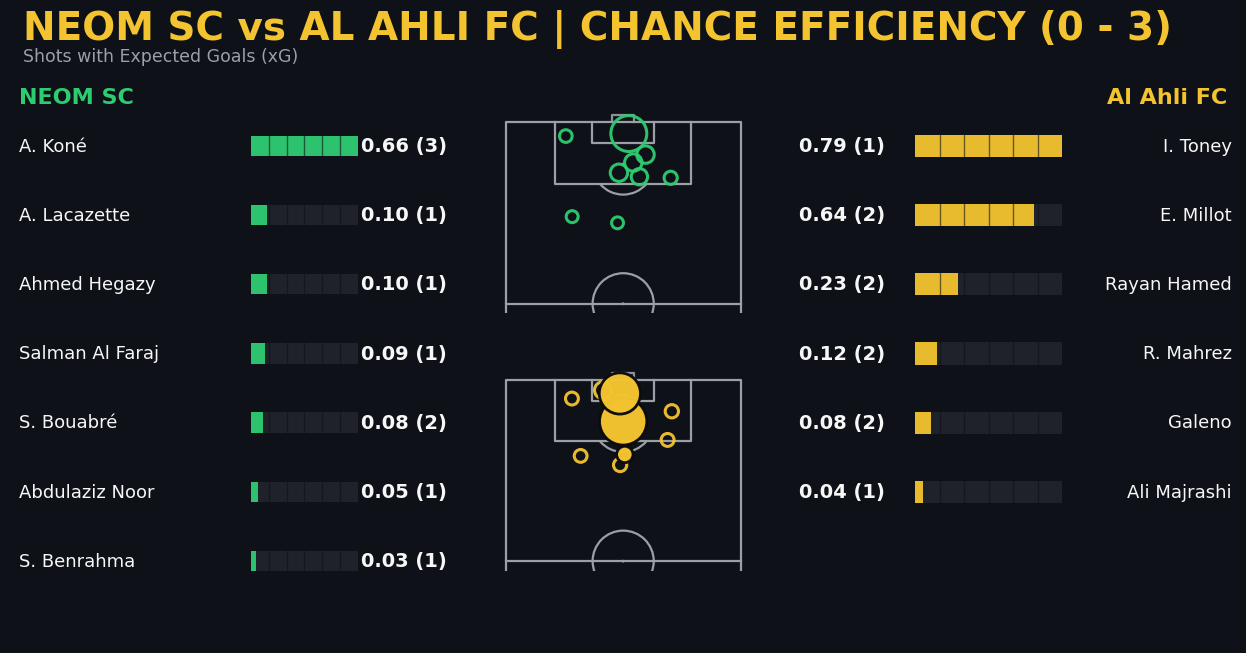

Saved: /Users/user/Downloads/Post-Match NEOM/Page 5.png


In [5]:
# Chance Efficiency (Shots + xG) using PlayerId — FULL CODE (with match-style header)
# Updates included:
# - Header like your example: "HOME vs AWAY | CHANCE EFFICIENCY (scoreline)" + subtitle
# - xG shows shots count: "0.54 (2)" (shots in parentheses behind xG)
# - Remove separate shots-number column
# - VerticalPitch half=True for BOTH mini pitches
# - Home shots ONLY on top pitch, Away shots ONLY on bottom pitch
# - Align first row on both sides (shared y-grid)
# - Extra room between right bars and names (bar ends earlier)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mplsoccer.pitch import VerticalPitch

# ---------------------
# INPUTS
# ---------------------
CSV_PATH = "/Users/user/XG/Saudi/xgCSV/2026-01-24_NEOM SC - Al Ahli FC.csv"
OUT_PATH = "/Users/user/Downloads/Post-Match NEOM/Page 5.png"

# ---------------------
# COLORS (your palette)
# ---------------------
COLORS = {
    "yellow": "#F4C430",
    "black": "#0B0B0B",
    "white": "#F7F7F7",
    "grey": "#9AA0A6",
    "emerald": "#2ECC71",
    "background": "#0e1117",
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "axes.labelcolor": COLORS["white"],
    "xtick.color": COLORS["grey"],
    "ytick.color": COLORS["grey"],
    "font.family": "DejaVu Sans",
})

# ---------------------
# HELPERS
# ---------------------
def _to_bool(v):
    if isinstance(v, str):
        return v.strip().lower() in ("1", "true", "yes", "y", "t")
    return bool(v)

def _short_name(name: str) -> str:
    name = str(name).strip()
    if not name or name.lower() == "nan":
        return "—"
    parts = name.split()
    if len(parts) == 1:
        return parts[0]
    return f"{parts[0][0]}. {' '.join(parts[1:])}"

def _top_players(df_team: pd.DataFrame, n: int):
    if "PlayerId" not in df_team.columns:
        raise ValueError("CSV must contain 'PlayerId' for this plot.")

    tmp = df_team.copy()
    tmp["PlayerId"] = tmp["PlayerId"].astype(str)
    tmp["xG"] = pd.to_numeric(tmp["xG"], errors="coerce").fillna(0.0)

    # label: use playerName if present, else PlayerId
    if "playerName" in tmp.columns:
        name_map = (
            tmp.groupby("PlayerId")["playerName"]
            .agg(lambda s: s.dropna().astype(str).value_counts().index[0] if len(s.dropna()) else "")
        )
        tmp["_label"] = tmp["PlayerId"].map(lambda pid: _short_name(name_map.get(pid, "")))
    else:
        tmp["_label"] = tmp["PlayerId"]

    g = (tmp
         .groupby(["PlayerId", "_label"], dropna=False)
         .agg(shots=("xG", "size"), xg=("xG", "sum"))
         .reset_index())
    g["shots"] = g["shots"].astype(int)
    g["xg"] = g["xg"].astype(float)
    g = g.sort_values(["xg", "shots"], ascending=False).head(n).reset_index(drop=True)
    return g

def _draw_segmented_bar(ax, x0, y, w, h, value, vmax, fill_color,
                        track_color="#20242c", segments=6):
    """Segmented bar with dark track. Coordinates are axes-fraction."""
    vmax = float(vmax) if vmax else 1.0
    frac = max(0.0, min(1.0, float(value) / vmax))

    # track
    ax.add_patch(Rectangle((x0, y - h/2), w, h, transform=ax.transAxes,
                           facecolor=track_color, alpha=0.95, edgecolor="none", zorder=1))
    # fill
    ax.add_patch(Rectangle((x0, y - h/2), w * frac, h, transform=ax.transAxes,
                           facecolor=fill_color, alpha=0.95, edgecolor="none", zorder=2))
    # segments
    for i in range(1, segments):
        xi = x0 + w * i / segments
        ax.plot([xi, xi], [y - h/2, y + h/2], transform=ax.transAxes,
                color=COLORS["background"], alpha=0.60, lw=1, zorder=3)

def plot_shots_vertical_half(ax, vp: VerticalPitch, team_df, color, mirror: bool = False):
    """
    Plot shots on VerticalPitch half=True.
    mirror=True flips attacking direction (x only). (Do NOT flip y)
    """
    d = team_df.dropna(subset=["x", "y"]).copy()
    if d.empty:
        return

    x = pd.to_numeric(d["x"], errors="coerce").values.astype(float)
    y = pd.to_numeric(d["y"], errors="coerce").values.astype(float)
    xg = pd.to_numeric(d["xG"], errors="coerce").fillna(0).values.astype(float)

    if "isGoal" in d.columns:
        is_goal = d["isGoal"].apply(_to_bool).values.astype(bool)
    else:
        is_goal = np.zeros(len(d), dtype=bool)

    if mirror:
        x = 100 - x  # mirror only x

    sizes = np.clip(xg, 0, None) * 1200 + 35

    # misses hollow
    vp.scatter(
        x[~is_goal], y[~is_goal], ax=ax,
        s=sizes[~is_goal],
        facecolors="none",
        edgecolors=color,
        linewidths=2.2,
        alpha=0.95,
        zorder=4,
    )
    # goals filled
    vp.scatter(
        x[is_goal], y[is_goal], ax=ax,
        s=sizes[is_goal] * 1.18,
        c=color,
        edgecolors=COLORS["black"],
        linewidths=2.0,
        alpha=0.98,
        zorder=5,
    )

# ---------------------
# LOAD CSV
# ---------------------
df = pd.read_csv(CSV_PATH)

# remove 120+ penalties
if "timeMin" in df.columns and "Type_of_play" in df.columns:
    df = df[~((pd.to_numeric(df["timeMin"], errors="coerce") >= 120) & (df["Type_of_play"] == "Penalty"))].copy()

df["xG"] = pd.to_numeric(df.get("xG", 0), errors="coerce").fillna(0.0)
df["x"]  = pd.to_numeric(df.get("x", np.nan), errors="coerce")
df["y"]  = pd.to_numeric(df.get("y", np.nan), errors="coerce")

if "isGoal" in df.columns:
    df["isGoal"] = df["isGoal"].apply(_to_bool)
else:
    df["isGoal"] = False

home_team = str(df["HomeTeam"].iloc[0]) if "HomeTeam" in df.columns else "Home"
away_team = str(df["AwayTeam"].iloc[0]) if "AwayTeam" in df.columns else "Away"

# Goals for header (fallbacks)
home_goals = int(pd.to_numeric(df["HomeGoals"].iloc[0], errors="coerce")) if "HomeGoals" in df.columns else \
             (int(df.loc[(df.get("TeamId") == home_team) & (df["isGoal"] == True)].shape[0]) if "TeamId" in df.columns else int(df[df["isGoal"] == True].shape[0]))

away_goals = int(pd.to_numeric(df["AwayGoals"].iloc[0], errors="coerce")) if "AwayGoals" in df.columns else \
             (int(df.loc[(df.get("TeamId") == away_team) & (df["isGoal"] == True)].shape[0]) if "TeamId" in df.columns else 0)

# Team filtering (your original assumption: TeamId equals team name)
home = df[df["TeamId"] == home_team].copy() if "TeamId" in df.columns else df.copy()
away = df[df["TeamId"] == away_team].copy() if "TeamId" in df.columns else df.copy()

# fallback if your CSV uses teamName instead of TeamId
if home.empty and "teamName" in df.columns:
    home = df[df["teamName"] == home_team].copy()
if away.empty and "teamName" in df.columns:
    away = df[df["teamName"] == away_team].copy()

# ---------------------
# TOP PLAYERS
# ---------------------
left_tbl  = _top_players(home, n=8)
right_tbl = _top_players(away, n=6)

left_vmax  = float(left_tbl["xg"].max()) if len(left_tbl) else 1.0
right_vmax = float(right_tbl["xg"].max()) if len(right_tbl) else 1.0

# ---------------------
# FIGURE (PPT 16:9)
# ---------------------
fig = plt.figure(figsize=(13.33, 7.5), facecolor=COLORS["background"])
gs = fig.add_gridspec(
    1, 3,
    width_ratios=[1.55, 1.05, 1.55],
    left=0.04, right=0.96, top=0.88, bottom=0.10, wspace=0.04
)

axL = fig.add_subplot(gs[0, 0])
axC = fig.add_subplot(gs[0, 1])
axR = fig.add_subplot(gs[0, 2])

for ax in (axL, axC, axR):
    ax.set_facecolor(COLORS["background"])

# ---------------------
# HEADER (match-style title like your example)
# ---------------------
scoreline = f"{home_goals} - {away_goals}"
fig.text(
    0.05, 0.945,
    f"{home_team.upper()} vs {away_team.upper()} | CHANCE EFFICIENCY ({scoreline})",
    fontsize=28, fontweight="bold", color=COLORS["yellow"], ha="left", va="top"
)
fig.text(
    0.05, 0.895,
    "Shots with Expected Goals (xG)",
    fontsize=12.5, color=COLORS["grey"], ha="left", va="top"
)

# ---------------------
# SHARED ROW GRID (align first row height on both sides)
# ---------------------
n_rows = int(max(len(left_tbl), len(right_tbl), 1))
y_top_shared = 0.85
y_bot_shared = 0.14
dy_shared = (y_top_shared - y_bot_shared) / max(1, (n_rows - 1))

# ---------------------
# LEFT TABLE (Home): LABEL -> BAR -> xG(shots)
# ---------------------
axL.axis("off")
axL.text(0.02, 0.95, home_team, transform=axL.transAxes,
         ha="left", va="top", fontsize=16, fontweight="bold", color=COLORS["emerald"])

lx_label = 0.02
lx_bar   = 0.54
lw_bar   = 0.24
lx_xg    = 0.98
bar_hL   = 0.035

for i, row in left_tbl.iterrows():
    y = y_top_shared - i * dy_shared

    axL.text(lx_label, y, str(row["_label"]), transform=axL.transAxes,
             ha="left", va="center", fontsize=13, color=COLORS["white"], clip_on=True, zorder=10)

    _draw_segmented_bar(axL, lx_bar, y, lw_bar, bar_hL, float(row["xg"]), left_vmax, COLORS["emerald"])

    axL.text(lx_xg, y, f"{float(row['xg']):.2f} ({int(row['shots'])})",
             transform=axL.transAxes,
             ha="right", va="center", fontsize=14, fontweight="bold",
             color=COLORS["white"], zorder=10)

# ---------------------
# RIGHT TABLE (Away): xG(shots) -> BAR -> LABEL (MORE GAP)
# ---------------------
axR.axis("off")
axR.text(0.98, 0.95, away_team, transform=axR.transAxes,
         ha="right", va="top", fontsize=16, fontweight="bold", color=COLORS["yellow"])

rx_xg = 0.02

# Extra room between bars and names:
# Bar ends at 0.61 (0.28 + 0.33), leaving a big gap before label at 0.99
rx_bar   = 0.28
rw_bar   = 0.33    # bar_end = 0.61
rx_label = 0.99
bar_hR   = 0.038

for i, row in right_tbl.iterrows():
    y = y_top_shared - i * dy_shared

    axR.text(rx_xg, y, f"{float(row['xg']):.2f} ({int(row['shots'])})",
             transform=axR.transAxes,
             ha="left", va="center", fontsize=14, fontweight="bold",
             color=COLORS["white"], zorder=10)

    _draw_segmented_bar(axR, rx_bar, y, rw_bar, bar_hR, float(row["xg"]), right_vmax, COLORS["yellow"])

    axR.text(rx_label, y, str(row["_label"]), transform=axR.transAxes,
             ha="right", va="center", fontsize=13, color=COLORS["white"],
             clip_on=True, zorder=10)

# ---------------------
# CENTER: TWO VERTICAL HALF PITCHES
# ---------------------
axC.axis("off")

top_ax = axC.inset_axes([0.08, 0.56, 0.84, 0.35])
bot_ax = axC.inset_axes([0.08, 0.12, 0.84, 0.35])

for a in (top_ax, bot_ax):
    a.set_facecolor(COLORS["background"])
    a.axis("off")

vp = VerticalPitch(
    pitch_type="opta",
    pitch_length=105,
    pitch_width=68,
    half=True,
    pitch_color=COLORS["background"],
    line_color=COLORS["grey"],
    linewidth=1.6,
    goal_type="box",
    goal_alpha=0.90,
)

vp.draw(ax=top_ax)
vp.draw(ax=bot_ax)

# Home only top, Away only bottom
plot_shots_vertical_half(top_ax, vp, home, COLORS["emerald"], mirror=False)
plot_shots_vertical_half(bot_ax, vp, away, COLORS["yellow"], mirror=False)

# ---------------------
# SAVE (PPT safe, no trimming)
# ---------------------
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
fig.savefig(
    OUT_PATH,
    dpi=300,
    facecolor=COLORS["background"],
    bbox_inches=None,     # don't trim
    pad_inches=0.0,
    transparent=False
)
plt.show()
print("Saved:", OUT_PATH)


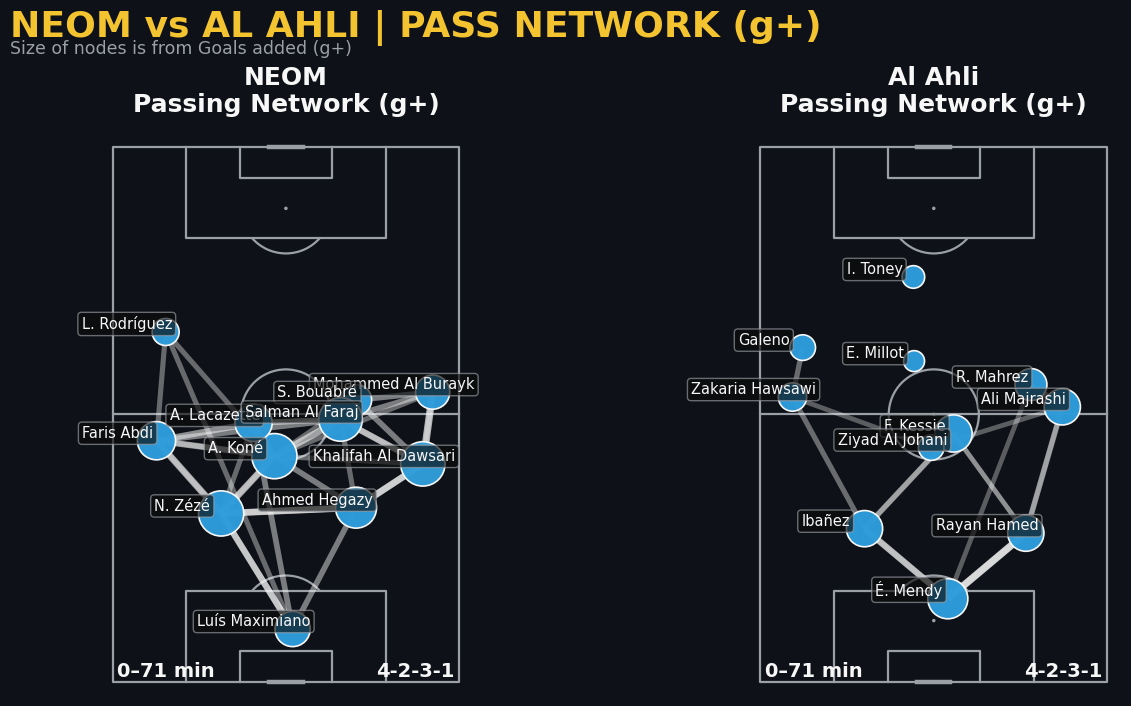

Saved: /Users/user/Downloads/Post-Match NEOM/Page 6.png


In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mplsoccer import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import os
import re

# ===========================
# 0. Paths (edit if needed)
# ===========================
json_path = '/Users/user/XG/Saudi/DONE/2026-01-24_NEOM SC - Al Ahli FC.json'
event_map_csv = "/Users/user/opta-events.csv"
team_mapping_file = "/Users/user/XG/Saudi Matches.csv"
badge_folder = "/Users/user/Logo/"
central_logo_path = "/Users/user/Logo/s.png"
output_png = "/Users/user/Downloads/Post-Match NEOM/Page 6.png"

# ===========================
# 0.0 Style (PPT-safe) + requested colors
# ===========================
COLORS = {
    "yellow": "#F4C430",
    "green":  "#2ECC71",
    "blue":   "#2D9CDB",
    "red":    "#EB5757",
    "black":  "#0B0B0B",
    "white":  "#F7F7F7",
    "grey":   "#9AA0A6",
    "background": "#0e1117",
    "track": "#20242c",
}

plt.rcParams.update({
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "savefig.facecolor": COLORS["background"],
    "savefig.transparent": False,
    "text.color": COLORS["white"],
    "axes.labelcolor": COLORS["white"],
    "xtick.color": COLORS["grey"],
    "ytick.color": COLORS["grey"],
    "font.family": "DejaVu Sans",
})

# ===========================
# Helpers
# ===========================
def normalize_name(s: str) -> str:
    if s is None:
        return ""
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]", "", s)
    s = s.replace(" ", "")
    return s

def robust_team_norm(values: np.ndarray, span_mult: float = 1.8) -> TwoSlopeNorm:
    """
    Diverging normalization PER TEAM.
    Center = team median.
    Span = robust MAD-based scale * span_mult (tight => more visible differences).
    """
    v = np.asarray(values, dtype=float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return TwoSlopeNorm(vmin=-0.01, vcenter=0.0, vmax=0.01)

    center = float(np.median(v))

    mad = float(np.median(np.abs(v - center)))  # robust
    # convert MAD to sigma-ish
    sigma = 1.4826 * mad

    # fallback if MAD is 0 (all very similar) -> use percentile span
    if sigma < 1e-9:
        lo = float(np.percentile(v, 10))
        hi = float(np.percentile(v, 90))
        span = max(abs(center - lo), abs(hi - center), 1e-6)
    else:
        span = max(sigma * span_mult, 1e-6)

    return TwoSlopeNorm(vmin=center - span, vcenter=center, vmax=center + span)

# ===========================
# Diverging colormap (LOW -> RED, MID -> BLUE, HIGH -> GREEN)
# with YELLOW in the low band
# ===========================
div_cmap = LinearSegmentedColormap.from_list(
    "gplus_diverging",
    [
        (0.00, COLORS["red"]),
        (0.35, COLORS["yellow"]),
        (0.50, COLORS["blue"]),
        (1.00, COLORS["green"]),
    ],
    N=256
)

# ===========================
# 1. Load JSON
# ===========================
with open(json_path, 'r') as f:
    data = json.load(f)

events = data["event"]
rows = []
for e in events:
    row = {
        "id": e.get("id"),
        "eventId": e.get("eventId"),
        "typeId": e.get("typeId"),
        "periodId": e.get("periodId"),
        "timeMin": e.get("timeMin"),
        "timeSec": e.get("timeSec"),
        "contestantId": e.get("contestantId"),
        "playerId": e.get("playerId"),
        "playerName": e.get("playerName"),
        "outcome": e.get("outcome"),
        "x": e.get("x"),
        "y": e.get("y"),
        "timeStamp": e.get("timeStamp"),
        "lastModified": e.get("lastModified"),
    }
    for q in e.get("qualifier", []):
        qid = q["qualifierId"]
        val = q.get("value", 1)
        row[f"qualifier_{qid}"] = val
    rows.append(row)

df = pd.DataFrame(rows)

# ===========================
# 2. Merge Event Mapping
# ===========================
event_map = pd.read_csv(event_map_csv, encoding="ISO-8859-1")
event_map.columns = ["typeId", "Event Type", "Description"]
df = df.merge(event_map[["typeId", "Event Type"]], on="typeId", how="left")

# ===========================
# 3. Team Mapping
# ===========================
team_mapping_df = pd.read_csv(team_mapping_file)

home_teams = team_mapping_df[["matchInfo/contestant/0/id", "matchInfo/contestant/0/name"]].copy()
home_teams.columns = ["contestantId", "Team"]
away_teams = team_mapping_df[["matchInfo/contestant/1/id", "matchInfo/contestant/1/name"]].copy()
away_teams.columns = ["contestantId", "Team"]
team_map = pd.concat([home_teams, away_teams]).drop_duplicates()

id_to_name = dict(zip(team_map["contestantId"], team_map["Team"]))
name_to_id_norm = {}
for cid, name in id_to_name.items():
    name_to_id_norm.setdefault(normalize_name(name), cid)

# ===========================
# 4. Detect Home/Away from filename
# ===========================
json_filename = os.path.basename(json_path)
teams_part = os.path.splitext(json_filename)[0].split("_", 1)[1]
home_team_name_raw, away_team_name_raw = teams_part.split(" - ")

home_norm = normalize_name(home_team_name_raw)
away_norm = normalize_name(away_team_name_raw)

home_id = name_to_id_norm.get(home_norm)
away_id = name_to_id_norm.get(away_norm)

present_ids = list(df["contestantId"].dropna().unique())
if home_id is None or home_id not in present_ids or away_id is None or away_id not in present_ids:
    present_id_to_name = {cid: id_to_name.get(cid, str(cid)) for cid in present_ids}
    present_norm_to_id = {normalize_name(nm): cid for cid, nm in present_id_to_name.items()}
    home_id = present_norm_to_id.get(home_norm, present_ids[0] if present_ids else None)
    others = [cid for cid in present_ids if cid != home_id]
    away_id = present_norm_to_id.get(away_norm, (others[0] if others else None))

team_ids = [t for t in [home_id, away_id] if t is not None]

# ===========================
# 5. Compute custom g+
# ===========================
def compute_gplus(row):
    tid = row["typeId"]
    out = row["outcome"]
    base = 0.0

    if tid == 1:  # Pass
        if row.get("qualifier_1") == "2":
            base += 0.05 if out == 1 else -0.05
        if row.get("qualifier_196") and out == 1:
            base += 0.03
        if row.get("qualifier_4") and out == 1:
            base += 0.03

    if row.get("qualifier_210"):
        base += 0.05
        if tid == 16:
            base += 0.05

    gplus_lookup = {
        1: {1: 0.01, 0: 0.0}, 3: {1: 0.03, 0: -0.02}, 4: {1: -0.02},
        7: {1: 0.03, 0: 0.0}, 8: {1: 0.02, 0: 0.0}, 12: {1: 0.04},
        13: {1: 0.0, 0: 0.0}, 14: {1: 0.10, 0: 0.10}, 15: {1: 0.10, 0: 0.10},
        16: {1: 0.25, 0: 0.25}, 44: {1: 0.02, 0: -0.02}, 49: {1: 0.02},
        50: {1: -0.03}, 51: {1: -0.15},
    }
    if tid in gplus_lookup:
        base += gplus_lookup[tid].get(out, 0.0)
    return round(base, 4)

df["gplus"] = df.apply(compute_gplus, axis=1)
df["timeMin"] = pd.to_numeric(df["timeMin"], errors="coerce").fillna(0)
df["timeSec"] = pd.to_numeric(df["timeSec"], errors="coerce").fillna(0)
df["event_time_sec"] = df["timeMin"] * 60 + df["timeSec"]

# ===========================
# 6. Formation Extraction
# ===========================
formation_lookup = {
    '2': '4-4-2', '3': '4-1-2-1-2', '4': '4-3-3', '5': '4-5-1',
    '6': '4-4-1-1', '7': '4-1-4-1', '8': '4-2-3-1', '9': '4-3-2-1',
    '10': '5-3-2', '11': '5-4-1', '12': '3-5-2', '13': '3-4-3',
    '14': '3-1-3-1-2', '15': '4-2-2-2', '16': '3-5-1-1', '17': '3-4-2-1',
    '18': '3-4-1-2', '19': '3-1-4-2', '20': '3-4-3', '21': '4-1-3-2',
    '22': '4-2-4-0', '23': '4-3-1-2'
}
df["Formation"] = df.get("qualifier_130", np.nan).astype(str).map(formation_lookup)

# ===========================
# 7. Plot Passing Network (PPT ready)
# ===========================
# Ensure two teams
present_ids = list(df["contestantId"].dropna().unique())
if len(team_ids) < 2:
    for cid in present_ids:
        if cid not in team_ids:
            team_ids.append(cid)
        if len(team_ids) == 2:
            break

fig = plt.figure(figsize=(13.33, 7.5), facecolor=COLORS["background"])
gs = fig.add_gridspec(1, 2, left=0.04, right=0.96, top=0.84, bottom=0.08, wspace=0.12)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

pitch = VerticalPitch(
    pitch_type="opta",
    pitch_color=COLORS["background"],
    line_color=COLORS["grey"],
    linewidth=1.6,
    pad_top=6
)

home_name_hdr = id_to_name.get(team_ids[0], "HOME") if len(team_ids) > 0 else "HOME"
away_name_hdr = id_to_name.get(team_ids[1], "AWAY") if len(team_ids) > 1 else "AWAY"

fig.text(
    0.05, 0.995,
    f"{home_name_hdr.upper()} vs {away_name_hdr.upper()} | PASS NETWORK (g+)",
    fontsize=26, fontweight="bold", color=COLORS["yellow"], ha="left", va="top"
)
fig.text(
    0.05, 0.955,
    "Size of nodes is from Goals added (g+)",
    fontsize=12.5, color=COLORS["grey"], ha="left", va="top"
)

if os.path.exists(central_logo_path):
    logo_img = mpimg.imread(central_logo_path)
    imagebox = OffsetImage(logo_img, zoom=0.18)
    ab = AnnotationBbox(imagebox, (0.50, 0.49), frameon=False, xycoords="figure fraction", zorder=20)
    fig.add_artist(ab)

MIN_LINKS = 3
NODE_SCALE = 420.0
MIN_NODE = 70.0

for i, team_id in enumerate(team_ids[:2]):
    team_all = df[df["contestantId"] == team_id].copy()

    # First substitution cutoff
    sub_events = team_all[team_all["typeId"].isin([18, 19])]
    if not sub_events.empty:
        sub_time = float(sub_events["event_time_sec"].min())
        end_minute = int(sub_time // 60)
        team_filtered = team_all[team_all["event_time_sec"] < sub_time]
        time_range_text = f"0–{end_minute} min"
    else:
        team_filtered = team_all.copy()
        time_range_text = "Full Match"

    formation_counts = team_filtered["Formation"].dropna().value_counts()
    formation_name = formation_counts.idxmax() if not formation_counts.empty else "N/A"

    # Completed passes
    passes = team_filtered[(team_filtered["typeId"] == 1) & (team_filtered["outcome"] == 1)][
        ["playerName", "x", "y", "gplus"]
    ].dropna()

    passes = passes.copy()
    passes["recipient"] = passes["playerName"].shift(-1)

    # Node stats
    player_stats = passes.groupby("playerName").agg(
        x=("x", "mean"),
        y=("y", "mean"),
        gplus_sum=("gplus", "sum"),
        gplus_mean=("gplus", "mean"),
        n=("gplus", "size")
    )

    if not player_stats.empty:
        player_stats["size"] = np.maximum(MIN_NODE, np.clip(player_stats["gplus_sum"], 0.0, None) * NODE_SCALE)

    # Links
    pass_links = passes.groupby(["playerName", "recipient"]).size().reset_index(name="pass_count")
    if not pass_links.empty and not player_stats.empty:
        pass_links = pass_links.merge(player_stats, left_on="playerName", right_index=True)
        pass_links = pass_links.merge(player_stats, left_on="recipient", right_index=True, suffixes=("", "_end"))
        pass_links = pass_links[pass_links["pass_count"] >= MIN_LINKS]

    ax = axs[i]
    ax.set_facecolor(COLORS["background"])
    pitch.draw(ax=ax)

    # Lines always white
    if pass_links is not None and not pass_links.empty:
        max_link = int(pass_links["pass_count"].max()) if pass_links["pass_count"].max() else 1
        for _, r in pass_links.iterrows():
            alpha = 0.15 + 0.55 * (float(r["pass_count"]) / max_link)
            lw = 2.5 + 2.8 * (float(r["pass_count"]) / max_link)
            pitch.lines(
                r["x"], r["y"], r["x_end"], r["y_end"],
                color=COLORS["white"],
                lw=lw,
                alpha=alpha,
                ax=ax,
                zorder=2
            )

    # Nodes: DIVERGING colors PER TEAM (this is the key fix)
    if not player_stats.empty:
        vals = player_stats["gplus_mean"].astype(float).values

        # per-team norm => visible separation inside each panel
        norm_team = robust_team_norm(vals, span_mult=1.8)  # increase span_mult if too saturated

        rgba = div_cmap(norm_team(vals))
        rgba[:, 3] = 0.98  # vivid / no accidental transparency

        pitch.scatter(
            player_stats["x"], player_stats["y"],
            s=player_stats["size"],
            c=rgba,
            edgecolors=COLORS["white"],
            linewidth=1.2,
            ax=ax,
            zorder=3
        )

        for name, r in player_stats.iterrows():
            pitch.annotate(
                name,
                xy=(r["x"], r["y"]),
                ax=ax,
                ha="center",
                va="bottom",
                fontsize=10.5,
                color=COLORS["white"],
                xytext=(0, -28),
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.25", fc=COLORS["black"], ec=COLORS["grey"], alpha=0.65),
                zorder=4
            )

    team_name = id_to_name.get(team_id, str(team_id))
    title_color = COLORS["green"] if i == 0 else COLORS["yellow"]

    ax.set_title(f"{team_name}\nPassing Network (g+)", fontsize=18, color=COLORS["white"], pad=10, fontweight="bold")
    ax.text(0.05, 0.06, time_range_text, transform=ax.transAxes,
            fontsize=14, ha="left", va="top", color=COLORS["white"], fontweight="bold")
    ax.text(0.95, 0.06, formation_name, transform=ax.transAxes,
            fontsize=14, ha="right", va="top", color=COLORS["white"], fontweight="bold")

    # Badge
    badge_path_candidates = [
        os.path.join(badge_folder, f"{team_name}.png"),
        os.path.join(badge_folder, f"{team_name}.jpg"),
        os.path.join(badge_folder, f"{team_name}.jpeg"),
        os.path.join(badge_folder, f"{team_name}.webp"),
        os.path.join(badge_folder, f"{team_name}.PNG"),
    ]
    badge_path = next((p for p in badge_path_candidates if os.path.exists(p)), None)
    if badge_path:
        badge_img = mpimg.imread(badge_path)
        badge = OffsetImage(badge_img, zoom=0.18)
        badge_ab = AnnotationBbox(badge, (0.08, 1.05), xycoords="axes fraction", frameon=False, zorder=10)
        ax.add_artist(badge_ab)

    ax.plot([0.02, 0.20], [1.02, 1.02], transform=ax.transAxes,
            color=title_color, lw=4, solid_capstyle="round")

# ---------------------
# SAVE (PPT safe: no trimming)
# ---------------------
os.makedirs(os.path.dirname(output_png), exist_ok=True)
plt.savefig(
    output_png,
    dpi=300,
    facecolor=fig.get_facecolor(),
    bbox_inches=None,
    pad_inches=0.0,
    transparent=False
)
plt.show()

print(f"Saved: {output_png}")
